# Оценка глубины по монокулярной камере

In [1]:
import numpy as np
import cv2
import time

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print(cv2.__version__)
print(cv2.__file__)

4.6.0
/Users/almuravtsev/opt/anaconda3/envs/ya-profi-preparation-env/lib/python3.10/site-packages/cv2/__init__.py


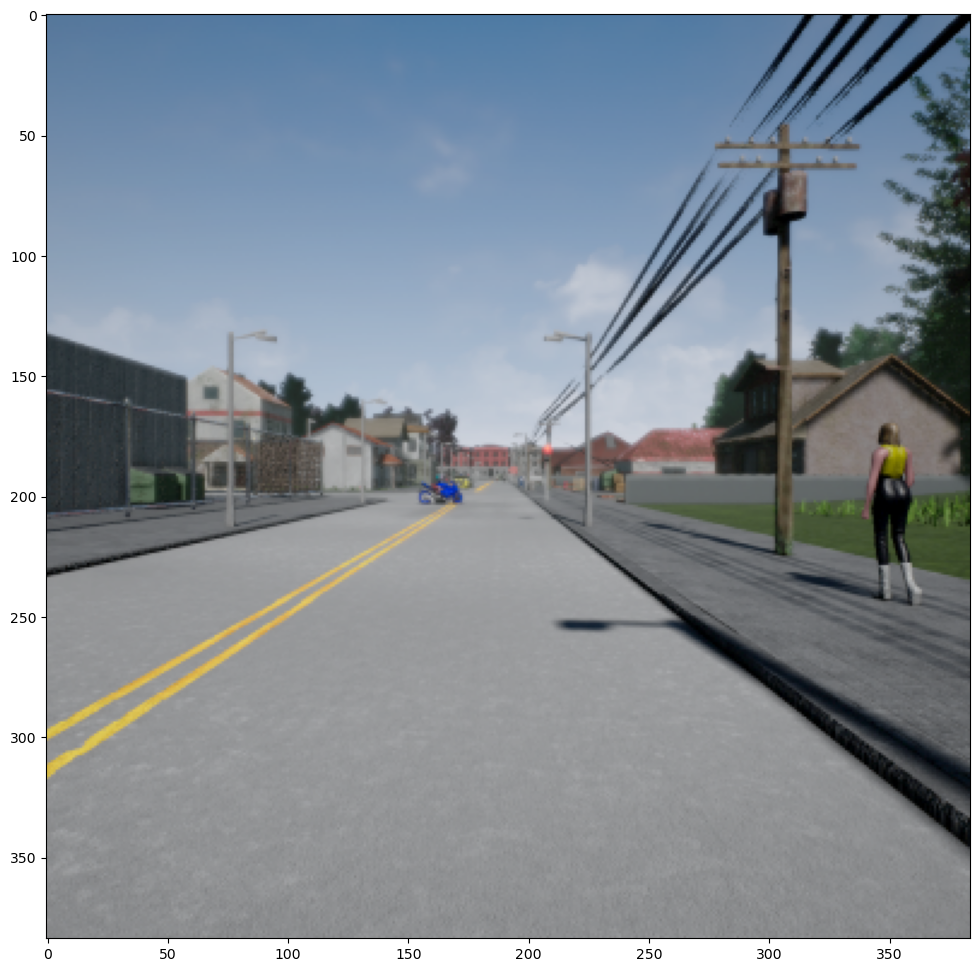

In [3]:
# Read the images
img = cv2.imread("../../datasets/mono-depth-estimation/file.png")[...,::-1]

plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(img)

In [4]:
path_model = "models/"

# Read Network
# model_name = "model-f6b98070.onnx"; # MiDaS v2.1 Large
model_name = "model-small.onnx"; # MiDaS v2.1 Small


# Load the DNN model
model = cv2.dnn.readNet(path_model + model_name)


if (model.empty()):
    print("Could not load the neural net! - Check path")


# Set backend and target to CUDA to use GPU
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [5]:
imgHeight, imgWidth, channels = img.shape
start = time.time()


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Create Blob from Input Image
# MiDaS v2.1 Small ( Scale : 1 / 255, Size : 256 x 256, Mean Subtraction : ( 123.675, 116.28, 103.53 ), Channels Order : RGB )
blob = cv2.dnn.blobFromImage(img, 1/255., (256,256), (123.675, 116.28, 103.53), True, False)

blob.shape

(1, 3, 256, 256)

[ WARN:0@1.349] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/dnn/src/net_impl.cpp (179) setUpNet DNN module was not built with CUDA backend; switching to CPU


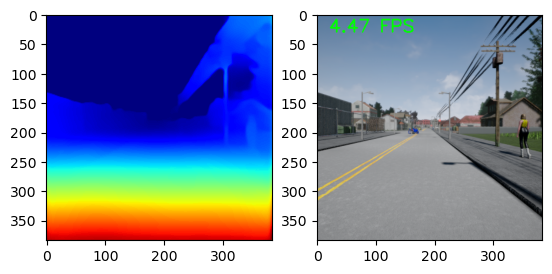

In [6]:
# Set input to the model
model.setInput(blob)

# Make forward pass in model
output = model.forward()

output = output[0,:,:]
output = cv2.resize(output, (imgWidth, imgHeight))

# Normalize the output
output = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# End time
end = time.time()
# calculate the FPS for current frame detection
fps = 1 / (end-start)
# Show FPS
cv2.putText(img, f"{fps:.2f} FPS", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# plt.figure(figsize=(8, 6), dpi=100)
# cv2.imshow('image', img)
# plt.imshow(output, cmap='jet')

f, axarr = plt.subplots(1,2)
axarr[0].imshow(output, cmap='jet')
axarr[1].imshow(img)

In [7]:
# from onboard camera

cap = cv2.VideoCapture(0)

cv2.startWindowThread()

while cap.isOpened():

    # Read in the image
    success, img = cap.read()

    imgHeight, imgWidth, channels = img.shape

    # start time to calculate FPS
    start = time.time()


    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    # Create Blob from Input Image
    # MiDaS v2.1 Large ( Scale : 1 / 255, Size : 384 x 384, Mean Subtraction : ( 123.675, 116.28, 103.53 ), Channels Order : RGB )
    #blob = cv2.dnn.blobFromImage(img, 1/255., (384,384), (123.675, 116.28, 103.53), True, False)

    # MiDaS v2.1 Small ( Scale : 1 / 255, Size : 256 x 256, Mean Subtraction : ( 123.675, 116.28, 103.53 ), Channels Order : RGB )
    blob = cv2.dnn.blobFromImage(img, 1/255., (256,256), (123.675, 116.28, 103.53), True, False)

    # Set input to the model
    model.setInput(blob)

    # Make forward pass in model
    output = model.forward()
    
    output = output[0,:,:]
    output = cv2.resize(output, (imgWidth, imgHeight))

    # Normalize the output
    output = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # End time
    end = time.time()
    # calculate the FPS for current frame detection
    fps = 1 / (end-start)
    # Show FPS
    cv2.putText(img, f"{fps:.2f} FPS", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    cv2.imshow('image', img)
    cv2.imshow('Depth Map', output)


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.waitKey(2000)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1